# Simulación Computacional de un Cohete en Europa
Kevin Velasquez Gonzalez - CC:1001686775

Ana Paulina Olivares Álvarez - CC:1000192042

Eylen Adriana Martínez Medrano - CC: 1137976936

**simulación del despegue y reingreso forzado de un cohete autónomo en Europa (luna de Júpiter)**, considerando:

- Masa variable (consumo de combustible)
- Empuje por eyección de gases
- Gravedad local (Europa ~ 1.315 m/s²)
- Fuerza de arrastre (atmósfera tenue)
- Integración numérica con **Runge-Kutta 4 (RK4)**
- Cálculo de energías (cinética, potencial, total)
- Pérdidas acumuladas por fricción
- Detección de eventos críticos (fin del combustible, apogeo, retorno al suelo)

Al final, se generan **gráficas y tablas de resultados**.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass, asdict

## Parámetros del cohete

parámetros físicos y numéricos de la simulación.


In [20]:
@dataclass
class ParametrosCohete:
    g: float = 1.315      # gravedad en Europa (m/s^2)
    m0: float = 1500.0    # masa inicial total (kg)
    m_m_seco: float = 900.0  # masa en seco (kg)
    mdot: float = 5.0     # ritmo de consumo de combustible (kg/s)
    ve: float = 2000.0    # velocidad de eyección de gases (m/s)
    Cd: float = 0.5       # coeficiente de arrastre
    A: float = 1.0        # área de referencia (m^2)
    rho: float = 1e-7     # densidad atmosférica (kg/m^3)
    y0: float = 0.0       # altura inicial (m)
    v0: float = 0.0       # velocidad inicial (m/s)
    dt: float = 0.05      # paso de integración (s)
    t_max: float = 1500 # tiempo máximo de simulación (s)

# Crear parámetros por defecto
p = ParametrosCohete()


## Dinámica del cohete

funciones que describen el movimiento:
- Masa en función del tiempo
- Empuje
- Arrastre
- Dinámica de la segunda ley de Newton
- Integrador Runge-Kutta 4 (RK4)


In [23]:
def empuje_y_masa(t, p: ParametrosCohete, m):
    combustible_masa = p.m0 - p.m_m_seco
    t_quemado = combustible_masa / p.mdot if p.mdot > 0 else 0.0
    if t < t_quemado and m > p.m_m_seco:
        return p.mdot * p.ve, p.mdot
    else:
        return 0.0, 0.0

def masa_en_tiempo(t, p: ParametrosCohete):
    combustible_masa = p.m0 - p.m_m_seco
    if p.mdot <= 0:
        return p.m0
    t_quemado = combustible_masa / p.mdot
    if t <= t_quemado:
        return p.m0 - p.mdot * t
    else:
        return p.m_m_seco

def fuerza_arrastre(v, p: ParametrosCohete, con_arrastre=True):
    if not con_arrastre:
        return 0.0
    return 0.5 * p.Cd * p.rho * p.A * v * abs(v)

def dinamica(t, y, v, p: ParametrosCohete, con_arrastre=True):
    m = masa_en_tiempo(t, p)
    T, _ = empuje_y_masa(t, p, m)
    D = fuerza_arrastre(v, p, con_arrastre=con_arrastre)
    a = (T - D - m * p.g) / m
    return v, a

def rk4_paso(t, y, v, h, p: ParametrosCohete, con_arrastre=True):
    k1_y, k1_v = dinamica(t, y, v, p, con_arrastre)
    k2_y, k2_v = dinamica(t + 0.5*h, y + 0.5*h*k1_y, v + 0.5*h*k1_v, p, con_arrastre)
    k3_y, k3_v = dinamica(t + 0.5*h, y + 0.5*h*k2_y, v + 0.5*h*k2_v, p, con_arrastre)
    k4_y, k4_v = dinamica(t + h, y + h*k3_y, v + h*k3_v, p, con_arrastre)
    y_new = y + (h/6.0)*(k1_y + 2*k2_y + 2*k3_y + k4_y)
    v_new = v + (h/6.0)*(k1_v + 2*k2_v + 2*k3_v + k4_v)
    return y_new, v_new


## Simulación del movimiento

Integracion de la dinámica paso a paso hasta que el cohete regrese al suelo.


In [24]:
def simular(p: ParametrosCohete, con_arrastre=True):
    dt = p.dt
    t, y, v = 0.0, p.y0, p.v0

    t_lista, y_lista, v_lista, a_lista, m_lista = [t], [y], [v], [], [masa_en_tiempo(t, p)]

    # Eventos
    tiempo_quemado, tiempo_apogeo, tiempo_suelo = None, None, None

    while t < p.t_max:
        m = masa_en_tiempo(t, p)
        _, a = dinamica(t, y, v, p, con_arrastre=con_arrastre)
        a_lista.append(a)

        y_siguiente, v_siguiente = rk4_paso(t, y, v, dt, p, con_arrastre=con_arrastre)

        # Detectar apogeo
        if tiempo_apogeo is None and v > 0 and v_siguiente <= 0:
            tiempo_apogeo = t

        # Detectar retorno
        if tiempo_suelo is None and y > 0 and y_siguiente <= 0:
            tiempo_suelo = t
            break

        # Avanzar
        t += dt
        y, v = y_siguiente, v_siguiente
        t_lista.append(t)
        y_lista.append(y)
        v_lista.append(v)
        m_lista.append(masa_en_tiempo(t, p))

    return {
        "t": np.array(t_lista),
        "y": np.array(y_lista),
        "v": np.array(v_lista),
        "a": np.array(a_lista + [a_lista[-1]]),
        "m": np.array(m_lista),
        "tiempo_apogeo": tiempo_apogeo,
        "tiempo_suelo": tiempo_suelo
    }

# Ejecutar simulación con arrastre
sim_drag = simular(p, con_arrastre=True)


## Visualización

Graficas resultados principales: altura, velocidad, aceleración y masa en función del tiempo.


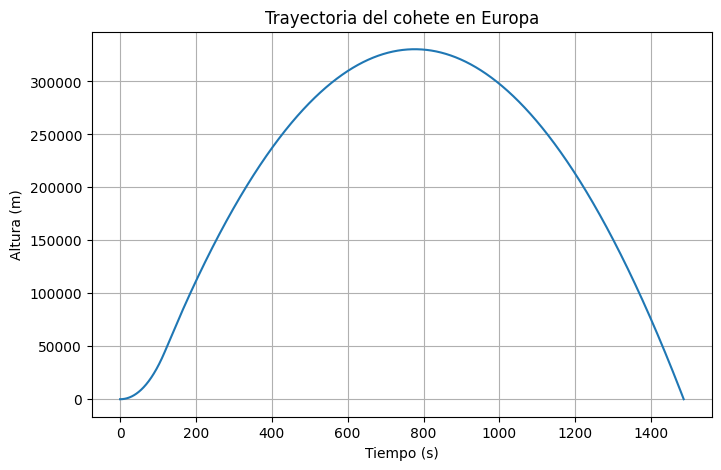

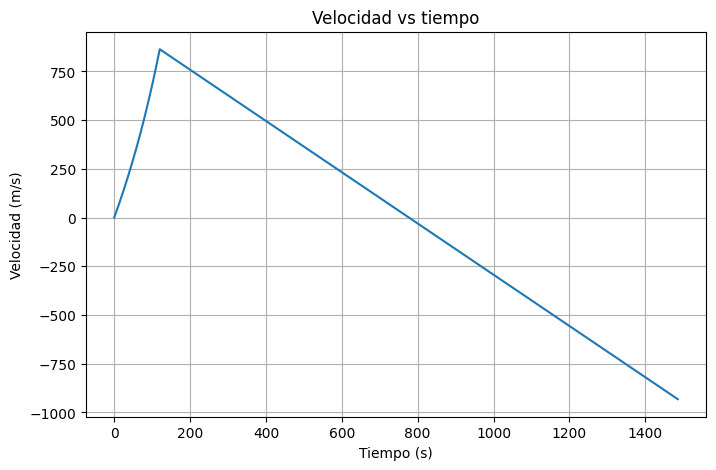

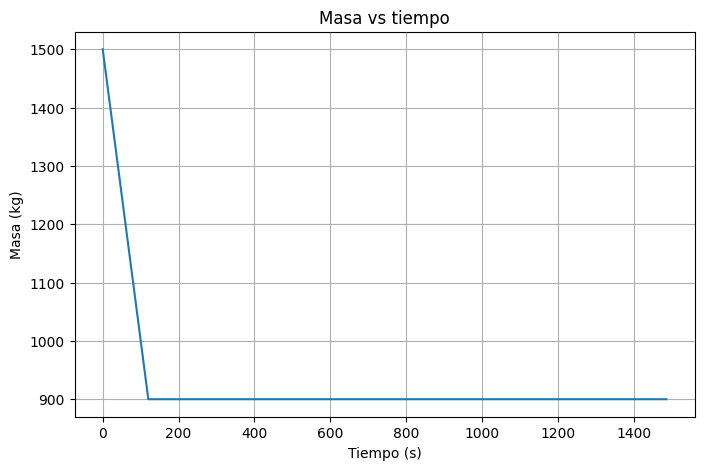

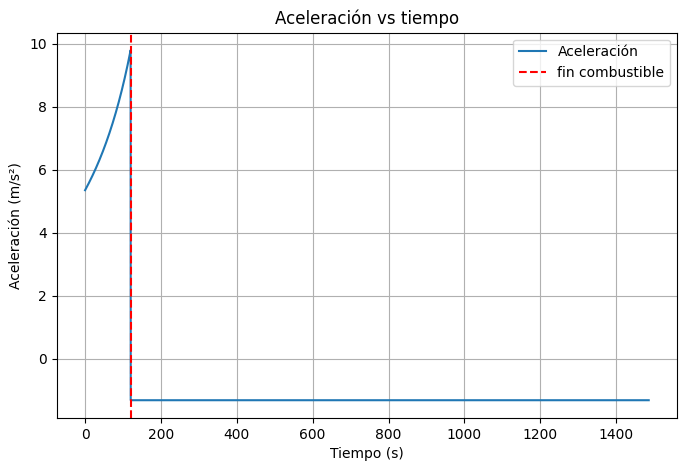

In [33]:
plt.figure(figsize=(8,5))
plt.plot(sim_drag["t"], sim_drag["y"])
plt.xlabel("Tiempo (s)"); plt.ylabel("Altura (m)"); plt.title("Trayectoria del cohete en Europa")
plt.grid()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(sim_drag["t"], sim_drag["v"])
plt.xlabel("Tiempo (s)"); plt.ylabel("Velocidad (m/s)"); plt.title("Velocidad vs tiempo")
plt.grid()
plt.show()


plt.figure(figsize=(8,5))
plt.plot(sim_drag["t"], sim_drag["m"])
plt.xlabel("Tiempo (s)"); plt.ylabel("Masa (kg)"); plt.title("Masa vs tiempo")
plt.grid()
plt.show()
# tiempo de quemado
t_quemadoout = (p.m0 - p.m_m_seco)/p.mdot if p.mdot > 0 else None

plt.figure(figsize=(8,5))
plt.plot(sim_drag["t"], sim_drag["a"][:len(sim_drag["t"])], label="Aceleración")
if t_quemadoout is not None:
    plt.axvline(t_quemadoout, color="red", linestyle="--", label="fin combustible")
plt.xlabel("Tiempo (s)")
plt.ylabel("Aceleración (m/s²)")
plt.title("Aceleración vs tiempo")
plt.legend()
plt.grid()
plt.show()


## Eventos detectados

eventos clave de la simulación.


In [14]:
print("Tiempo de apogeo (s):", sim_drag["tiempo_apogeo"])
print("Tiempo de retorno al suelo (s):", sim_drag["tiempo_suelo"])
print("Altura máxima (m):", np.max(sim_drag["y"]))

Tiempo de apogeo (s): 776.9499999998411
Tiempo de retorno al suelo (s): 1485.8999999991963
Altura máxima (m): 330433.99997607054


## Energías

Calculo y graficas:
- Energía cinética (Ec)
- Energía potencial gravitatoria (Ep)
- Energía total (Ec + Ep)
- Pérdidas acumuladas por fricción atmosférica


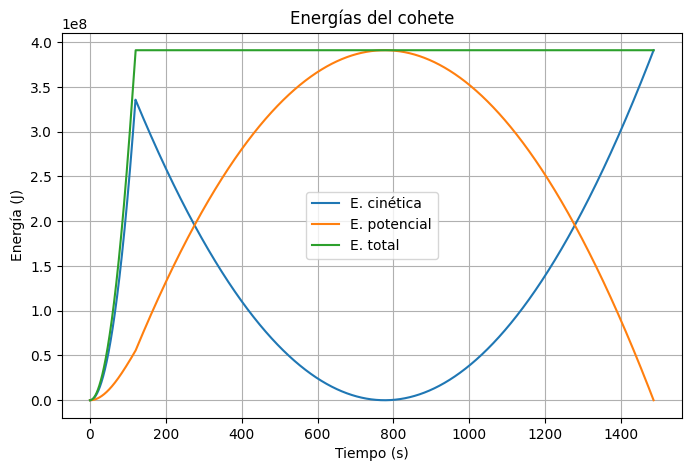

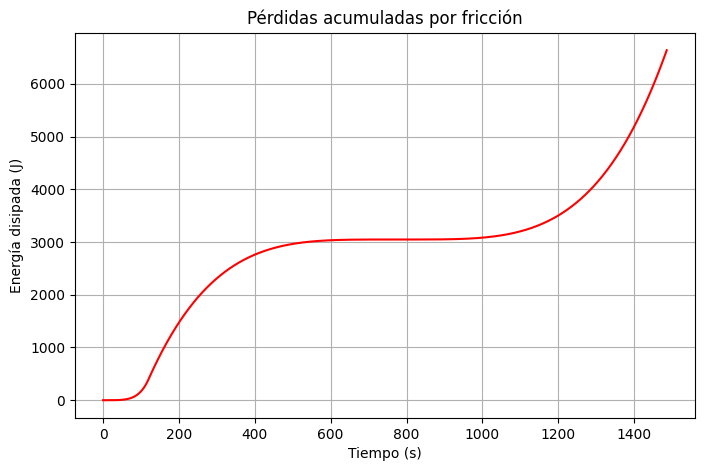

In [32]:
# Cálculo de energías
m = sim_drag["m"]
v = sim_drag["v"]
y = sim_drag["y"]
t = sim_drag["t"]

Ec = 0.5 * m * v**2
Ep = m * p.g * y
Et = Ec + Ep

# Pérdidas por fricción (potencia disipada integrada)
D = [fuerza_arrastre(vi, p, con_arrastre=True) for vi in v]
P_drag = np.abs(D) * np.abs(v)
E_loss = np.cumsum(P_drag) * p.dt

# Graficar energías
plt.figure(figsize=(8,5))
plt.plot(t, Ec, label="E. cinética")
plt.plot(t, Ep, label="E. potencial")
plt.plot(t, Et, label="E. total")
plt.xlabel("Tiempo (s)"); plt.ylabel("Energía (J)"); plt.title("Energías del cohete")
plt.legend()
plt.grid()
plt.show()

# Graficar pérdidas por fricción
plt.figure(figsize=(8,5))
plt.plot(t, E_loss, color="red")
plt.xlabel("Tiempo (s)"); plt.ylabel("Energía disipada (J)")
plt.title("Pérdidas acumuladas por fricción")
plt.grid()
plt.show()